# SKAB Data Set Creation
In this notebook, we create TS from the SKAB data archive.

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import numpy as np
import daproli as dp
import pandas as pd

pd.set_option('display.max_rows', None)

import seaborn as sns

sns.set_theme()
sns.set_color_codes()

import os
import sys

sys.path.append("../../")

from src.visualization import plot_time_series

First, we need to download the SKAB data archive from https://github.com/waico/SKAB/tree/master/data and place it into the DATA_PATH folder.

In [3]:
DATA_PATH = "../../archives/SKAB/"

Now, let’s define the relevant folders ands TS ids that we want to to load.

In [59]:
folders = [
    ("valve1", np.arange(0,16)),
    ("valve2", np.arange(0,4)),
    ("other", np.arange(1,15)),
]

Going on, we define the sensors we want to extract (all).

In [17]:
cols = [
    "Accelerometer1RMS", 
    "Accelerometer2RMS",
    "Current",
    "Pressure",
    "Temperature",
    "Thermocouple",
    "Voltage",
    "Volume Flow RateRMS"
]

Now, we define a helper procedure to extract change points and labels from a series of anomaly and change point annoations.

In [49]:
def extract_annotations(anomaly_seq, cp_seq):
    cps = list()
    labels = [anomaly_seq.iloc[0]]
    
    for cp in np.arange(cp_seq.shape[0])[cp_seq.to_numpy() == 1]:
        label = anomaly_seq.iloc[cp]
        
        if label != labels[-1]:
            cps.append(cp)
            labels.append(label)
    
    return np.array(cps, dtype=int), np.array(labels, dtype=int)

Let's write the function to load the requested time series with annotated change points and labels.

In [50]:
def load_skab_ts(folder, ts_id, resample_rate=1):
    df = pd.read_csv(os.path.join(DATA_PATH, folder, f"{ts_id}.csv"), sep=";", index_col='datetime', parse_dates=True)

    # Resample data frame
    df = df.iloc[::resample_rate, :]

    name = f"SKAB_{folder}_{ts_id}"
    cps, labels = extract_annotations(df.anomaly, df.changepoint)
    ts = []

    for col_name in cols:
        ts.append(df[col_name].to_numpy())

    return name, np.array(ts), cps, labels

Now, let's load a recording and explore it.

<Figure size 640x480 with 0 Axes>

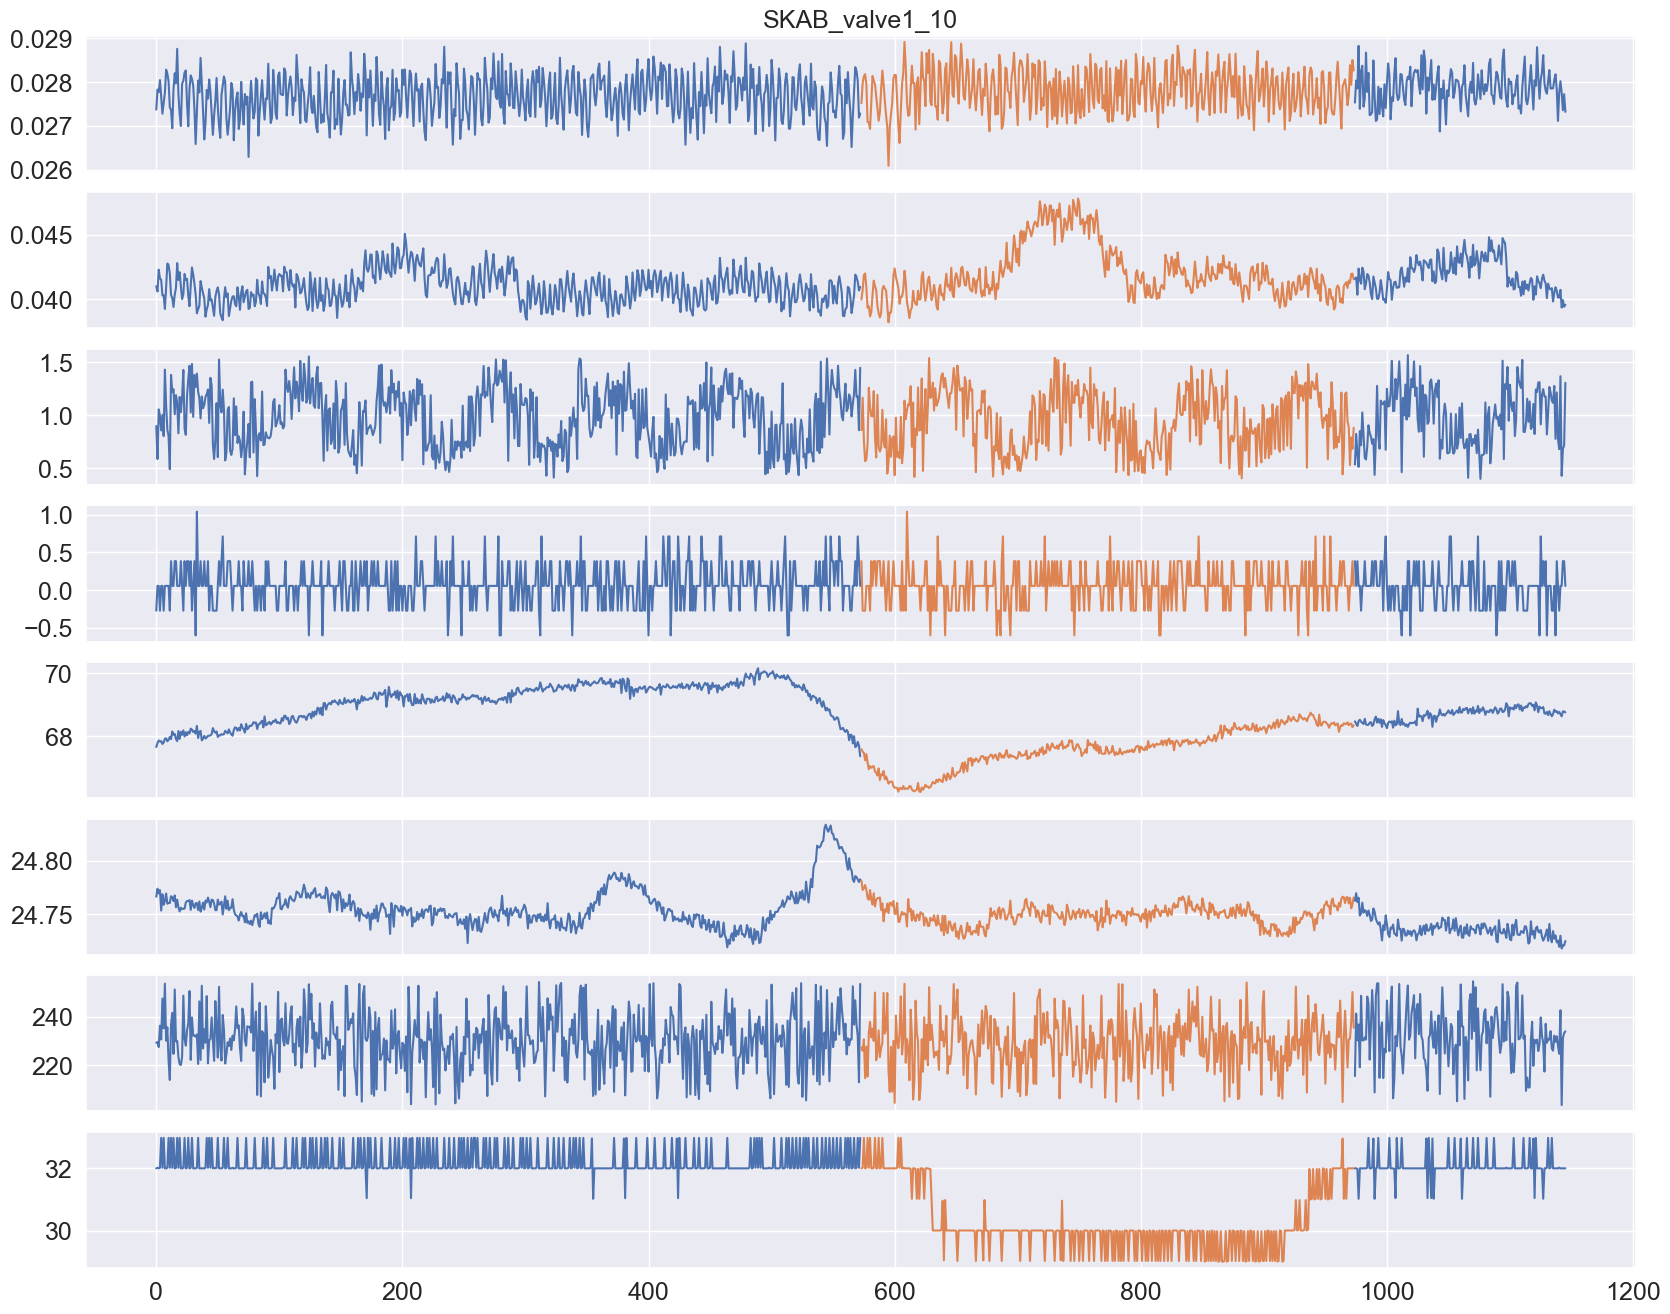

[0 1 0]


In [67]:
name, ts, cps, labels = load_skab_ts("valve1", 10)

plot_time_series(
    name,
    ts,
    cps,
    labels,
    show=True
)

print(labels)

Finally, let's create and save the TS dataset.

In [62]:
DATASET_PATH = "../../datasets/SKAB/"

In [63]:
if not os.path.exists(DATASET_PATH):
    os.mkdir(DATASET_PATH)

In [68]:
desc, prop = [], []
data = dict()
window_size = 95

for folder, ts_ids in folders:
    for ts_id in ts_ids:
        name, ts, cps, labels = load_skab_ts(folder, ts_id)

        desc.append(f"{name},{window_size},{','.join(dp.map(str, cps))}")
        prop.append(f"{name},{','.join(dp.map(str, labels))}")
        data[name] = ts.T

np.savetxt(f"{DATASET_PATH}desc.txt", desc, fmt="%s")
np.savetxt(f"{DATASET_PATH}properties.txt", prop, fmt="%s")
np.savez(f"{DATASET_PATH}data.npz", **data)